In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load Excel file with clusters
clusters_df = pd.read_excel('/Users/aaryanshah/Oncampus-Job/NLP_Gal/clustering/Clusters_gal.xlsx')

# Load CSV file with business descriptions
business_df = pd.read_csv('/Users/aaryanshah/Oncampus-Job/NLP_Gal/data/CVC_Combined_Scores_BERT_and_Rule_based.csv')

# Assume the business description column is named 'Business_Description'
business_descriptions = business_df['Business Description'].dropna()

# Tokenize and clean the text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_and_tokenize(text):
    words = word_tokenize(text.lower())
    return [word for word in words if word.isalnum() and word not in stop_words]

# Apply tokenization
tokenized_descriptions = business_descriptions.apply(clean_and_tokenize)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aaryanshah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aaryanshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load pre-trained word embeddings
import gensim.downloader as api

word_vectors = api.load('glove-wiki-gigaword-100')

# Function to calculate the centroid of a cluster
def get_cluster_centroid(words):
    vectors = [word_vectors[word] for word in words if word in word_vectors]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)  # Size of the embeddings

# Calculate centroids for each cluster
cluster_centroids = {}
for column in clusters_df.columns:
    cluster_words = clusters_df[column].dropna().tolist()
    cluster_centroids[column] = get_cluster_centroid(cluster_words)


/Users/aaryanshah/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
# Function to assign words to the closest cluster
def assign_cluster(word):
    if word not in word_vectors:
        return None
    word_vec = word_vectors[word]
    similarities = {cluster: cosine_similarity([word_vec], [centroid])[0][0] for cluster, centroid in cluster_centroids.items()}
    return max(similarities, key=similarities.get)

# Apply clustering to each word in each business description
assigned_clusters = tokenized_descriptions.apply(lambda desc: [assign_cluster(word) for word in desc])


In [5]:
assigned_clusters.to_csv('/Users/aaryanshah/Oncampus-Job/NLP_Gal/data/CVC_new_assigned_clusters.csv', index=False)

# reformatted

In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim.downloader as api

# Load data
clusters_df = pd.read_excel('/Users/aaryanshah/Oncampus-Job/NLP_Gal/clustering/Clusters_gal.xlsx')
business_df = pd.read_csv('/Users/aaryanshah/Oncampus-Job/NLP_Gal/data/CVC_Combined_Scores_BERT_and_Rule_based.csv')

# Preprocess descriptions
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_and_tokenize(text):
    words = word_tokenize(text.lower())
    return [word for word in words if word.isalnum() and not word in stop_words]

business_descriptions = business_df['Business Description'].dropna()
tokenized_descriptions = business_descriptions.apply(clean_and_tokenize)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aaryanshah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aaryanshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Load word embeddings
word_vectors = api.load('glove-wiki-gigaword-100')

def get_cluster_centroid(words):
    vectors = [word_vectors[word] for word in words if word in word_vectors]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

# Exclude clusters named 'Leftovers'
cluster_centroids = {}
for column in clusters_df.columns:
    if "Leftovers" not in column:
        cluster_words = clusters_df[column].dropna().tolist()
        cluster_centroids[column] = get_cluster_centroid(cluster_words)


In [5]:
from sklearn.metrics.pairwise import cosine_similarity

def assign_cluster(word):
    if word not in word_vectors:
        return None
    word_vec = word_vectors[word]
    similarities = {cluster: cosine_similarity([word_vec], [centroid])[0][0] for cluster, centroid in cluster_centroids.items()}
    return max(similarities, key=similarities.get)

# Store results in a dictionary by cluster
cluster_assignments = {}

for description in tokenized_descriptions:
    for word in description:
        cluster = assign_cluster(word)
        if cluster:
            if cluster not in cluster_assignments:
                cluster_assignments[cluster] = []
            cluster_assignments[cluster].append(word)

# Removing duplicates and keeping unique words per cluster
for cluster in cluster_assignments:
    cluster_assignments[cluster] = list(set(cluster_assignments[cluster]))


In [7]:
cluster_assignments_df = pd.DataFrame.from_dict(cluster_assignments, orient='index')
cluster_assignments_df.to_csv('/Users/aaryanshah/Oncampus-Job/NLP_Gal/data/CVC_new_assigned_clusters_2.csv', index=False)

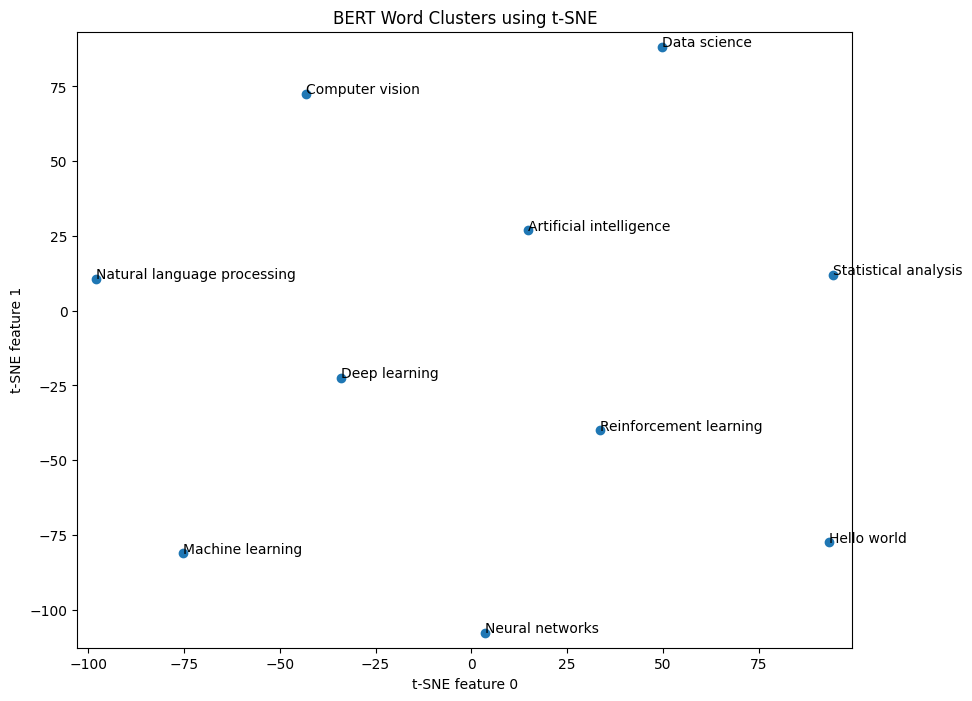

In [3]:
import torch
from transformers import BertModel, BertTokenizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states=True,  # Whether the model returns all hidden-states.
                                  )
model.eval()

# Function to get BERT embeddings
def get_bert_embeddings(text):
    # Add special tokens adds [CLS], [SEP] tokens
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(indexed_tokens)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    # Predict hidden states features for each layer
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]

    # Use the second to last hidden layer of each token
    token_vecs = hidden_states[-2][0]

    # Calculate the average of all token vectors.
    sentence_embedding = torch.mean(token_vecs, dim=0)
    return sentence_embedding.numpy()

# Example usage with more texts
texts = ["Hello world", "Machine learning", "Artificial intelligence", "Deep learning", "Natural language processing",
         "Data science", "Statistical analysis", "Neural networks", "Computer vision", "Reinforcement learning"]
embeddings = np.array([get_bert_embeddings(text) for text in texts])

# Dimensionality Reduction with t-SNE
tsne_perplexity = min(30, len(texts)-1)  # Adjust perplexity based on number of samples
tsne_model = TSNE(n_components=2, random_state=0, perplexity=tsne_perplexity)
tsne_data = tsne_model.fit_transform(embeddings)

# Plotting
x_coords = tsne_data[:, 0]
y_coords = tsne_data[:, 1]
plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords)

for i, text in enumerate(texts):
    plt.annotate(text, (x_coords[i], y_coords[i]))

plt.xlim(min(x_coords)-5, max(x_coords)+5)
plt.ylim(min(y_coords)-5, max(y_coords)+5)
plt.title('BERT Word Clusters using t-SNE')
plt.xlabel('t-SNE feature 0')
plt.ylabel('t-SNE feature 1')
plt.show()
